In [1]:
import os

os.chdir('C:\\Users\\gowra\\like_lion\\2.신경망\\신경망(클래스)/code/')

In [2]:
%pwd

'C:\\Users\\gowra\\like_lion\\2.신경망\\신경망(클래스)\\code'

#### Office31Dataset()클래스

In [3]:
%run dataset.ipynb

In [4]:
class Office31Dataset(Dataset):
    @property
    def base(self):
        return super(Office31Dataset, self)


    @property 데코레이터를 사용하여 base() 함수는 인수 없이 호출되는 속성 함수로 활용
    부모 클래스 메서드에 접근할 때 사용되는 super() 호출을 간단하게 표현하는데 사용되어 집니다.


##### __init__ 메서드 (데이터 불러오기)

In [5]:
def office31_init(self, resolution=[100, 100], input_shape=[-1]):
    self.base.__init__('office31', 'dual_select')
    path = 'C:/Users/gowra/like_lion/2.신경망/신경망(클래스)/office'
    
    domain_names = list_dir(path)  # 폴더의 이름(domain)을 반환
    #domain_names = 'amazon', 'dslr', 'webcam'
    
    images = []
    didxs, oidxs = [], []  #domain / office

    for dx, dname in enumerate(domain_names):
        domainpath = os.path.join(path, dname, 'images')
        # 'C:/Users/gowra/like_lion/2.신경망/신경망(클래스)/office/{dmain_name}/images'
        
        object_names = list_dir(domainpath) # domainpath 안에 있는 폴더명을 리스트로 가져옴
        for ox, oname in enumerate(object_names):
            objectpath = os.path.join(domainpath, oname)
             # 'C:/Users/gowra/like_lion/2.신경망/신경망(클래스)/office/{dmain_name}/images/{object_name}'
            filenames = list_dir(objectpath) # objectpath에 들어있는 이미지 이름을 리스트로 저장
            for fname in filenames:
                if fname[-4:] != '.jpg':  # 이미지 확장자가 jpg가 아니라면 pass
                    continue
                imagepath = os.path.join(objectpath, fname)
                # 'C:/Users/gowra/like_lion/2.신경망/신경망(클래스)/office/{dmain_name}/images/{object_name}/{image.jpg}'
                pixels = load_image_pixels(imagepath, resolution, input_shape) # 이미지에 대한 100x100으로 맞춰준뒤 1차원으로 변환
                images.append(pixels)
                didxs.append(dx) # 도메인에 관한 idx
                oidxs.append(ox)  # 오브젝트에 관한 idx
                
    self.image_shape = resolution + [3] # -1에서 3차원으로 복구하기위한 작업

    xs = np.asarray(images, np.float32) # 계산을 원활하게 하기위해 numpy로 만들어줌

    ys0 = onehot(didxs, len(domain_names)) # 원핫벡터로 만들기 위한 domain의 수
    ys1 = onehot(oidxs, len(object_names)) # 원핫벡터로 만들기 위한 object의 수
    ys = np.hstack([ys0, ys1]) # 행을 이어 붙여줌 [0,0,1 / , 0,0,0,1] domaain / object

    self.shuffle_data(xs, ys, 0.8) # train 80%로 잡고 shuffle 해준다.
    self.target_names = [domain_names, object_names] # domain과 object의 이름을 target으로 저장
    self.cnts = [len(domain_names)] # 도메인과 오브젝트를 구분하기위한 구분선으로 사용하기위해 지정

In [6]:
import numpy as np

y1 = [0,0,1]
y2 = [0,0,0,0,0,1]
y = np.hstack([y1,y2])
y

array([0, 0, 1, 0, 0, 0, 0, 0, 1])

    초기화  __init__ 메서드를 함수형식으로 구축하는 방식
    모드값 dual_select 은 기존의 'regression', 'binary', 'select' 디폴트 값에 속하지 않는 새로운 값이다.

    우선 폴더 구조를 살펴보면 office31 → 도메인 이름(3) → images → 객체 이름(31) →  이미지 파일 구조로 되어 있다. 
    그렇기에 도메인 이름과 객체 이름을 정답 라벨로 사용하기 위해 이전에 정의한 list_dir()를 통해 
    반환된 폴더명을 각각 domain_names, object_names 에 저장

    enumerate() 를 활용한 반복문을 사용하고 있는데, 여기서 수집된 dx와 ox는 append()를 통해 각각 didxs, oidxs에 누적 저장을 수행
    이렇게 저장된 리스트들은 이후 onehot() 를 통해 원 핫 벡터로 표현되어 집니다.

    도메인은 ys0, 오브젝트는 ys1 로 각각 저장되어 지지만, 우리가 원하는 바는 복합 출력입니다. 
    그렇기에 np.hstack() 를 통해 ys0과 ys1의 행을 연접시켜 정답 정보 ys를 만들어 주겠습니다. 
    이렇게 구해진 xs와 ys는 self.shuffle_data() 를 통해 데이터가 무작위로 섞여지며, 
    학습/검증/평가 로 나눠지는 과정을 진행하게 됩니다.

    마지막으로 self.cnts 를 도메인 수에 해당하는 값을 원소로 하는 리스트 [3]으로 지정하게 되는데, 
    이 값은 후처리 과정에서 여러 텐서를 도메인 부분과 오브젝트 부분으로 나눌 때 분할 위치를 나타내는 인덱스 역할을 하게 된다. 
    그리고 중간에 self.image_shape = resolution + [3] 의 과정을 통해 다시 1차원의 픽셀값을 이미지로 전환시켜 주고 있다. 
    이는 이전 꽃 이미지 과정과 마찬가지로 모든 3차원 이미지 데이터를 1차원 벡터 처리 후에 다시 3차원형식으로 전환하여 시각화처리를 위한 과정
    다소 복잡해 보이지만 복합 출력에 따른 도메인과 오브젝트 단위의 폴더 구조를 파악한다면 이전 꽃 이미지 방식과 매우 유사한 방식이라 할 수 있다.




##### 복합 출력을 위한 순전파 함수 office31_forward_postproc() 를 구축

In [7]:
def office31_forward_postproc(self, output, y):  #예측과 실제 정답을 구분하여 저장하는과정
    #np.hsplits(나누고자 하는 것, 몇개로)나누는 함수
    outputs, ys = np.hsplit(output, self.cnts), np.hsplit(y, self.cnts)  # 도메인의 수 만큼 나눠준다. (도메인/ 오브젝트)
    
    # Dataset() 클래스의 forward_postproc() 메서드로 접근
    # dual_select이 없기 때문에 'select'을 활용
    loss0, aux0 = self.base.forward_postproc(outputs[0], ys[0], 'select') # domain 값
    loss1, aux1 = self.base.forward_postproc(outputs[1], ys[1], 'select') # object 값

    # 손실 합산
    return loss0 + loss1, [aux0, aux1]

    MlpModel() 클래스에 있는 forward_postproc() 메서드를 재정의 
    복합 출력에 맞는 기능을 추가하는 메서드를 만들어야 합니다. 
    우선 신경망의 추측 output 과 실제 정답 y 를 전달받아 np.hsplit()를 통해 
    self.cnts 값인 [3] 만큼을 outputs 와 ys 의 0번째 행에, 나머지 3 이후의 값에 대해서는 1번째 행에 저장

    Dataset() 클래스의 forward_postproc() 메서드로 접근하여 다중 선택 분류 모드인 'select' 을 매개변수로 할당하고, 
    outputs 과 ys 도 각 행에 맞춰 전달해주도록 합니다.

    각 복합 출력에 따른 𝐿1, 𝐿2 를 얻게 되었을 때, 전체적인 손실 함수값은
    𝐿 = 𝐿1 + 𝐿2 로 정의하였습니다. 그리고 𝐿 을 최소화 하기 위한 노력은 결국 𝐿1과 𝐿2 를 줄이려는 노력으로 귀결되었습니다. 
    이 과정이 가능한 이유는 편미분의 특성과 𝐿1과 𝐿2 가 서로에게 상수로 간주된다는 점이었습니다. 
    그래서 메서드의 반환값으로 전달된 loss0, loss1 은 합산하여 전달해주도록 하겠습니다.


##### 역전파 함수를 정의

In [8]:
def office31_backprop_postproc(self, G_loss, aux):  # G_loss : delta 값
    aux0, aux1 = aux
    #역전파를 위한 G_OUTPUT구하기 \ G_OUTPUT0는 3개, G_OUTPUT1은 31개
    G_ouput0 = self.base.backprop_postproc(G_loss, aux0, 'select')
    G_ouput1 = self.base.backprop_postproc(G_loss, aux1, 'select')

    return np.hstack([G_ouput0, G_ouput1])  # 나눠서 구한 값을 다시 합쳐주고 있다.

    앞서 전달받은 aux0, aux1을 통해 도메인과 오브젝트의 다중 선택분류에 따른 G_outout을 구하는 과정입니다.
    마찬가지로 MlpModel() 클래스의 메서드를 재정의하여 Dataset() 클래스의 'select' 모드를 활용하여 주도록 하였습니다. 
    그리고 반환되어진 값은 이후 output 행렬과 손실 기울기를 구해야 하므로 같은 형태로 만들어 반환을 해줘야 하는데 
    이때 np.hstack() 를 통해 일렬로 반환하게 되면 문제없이 한번에  연산이 진행되어 집니다.


##### 평가를 위한 메서드를 정의

In [9]:
def office31_eval_accuracy(self, x, y, output):
    #예측 output과 실제값 y를 받아 각각 분할
    outputs, ys = np.hsplit(output, self.cnts), np.hsplit(y, self.cnts)
    
    # 값을 전달받아 Dataset에 있는 eval_accuracy()에 값을 전달하여 acc 구하기
    acc0 = self.base.eval_accuracy(x, ys[0], outputs[0], 'select') # base는 Dataset이라고 봐도 된다.
    acc1 = self.base.eval_accuracy(x, ys[1], outputs[1], 'select')

    return [acc0, acc1]

    정확도의 경우 앞서 loss를 구하는 과정과 비슷하지만 도메인과 오브젝트에 대한 결과는 각각 따로 반환하여 줍니다. 
    이 과정에서 Dataset() 클래스의 eval_accuracy() 메서드가 활용되어지는데, 
    앞서 loss를 구하는 과정에서 np.split()로 나눠진 값들을 여기에 다시 활용하여 주겠습니다.

    그리고 이렇게 구해진 acc0, acc1은 하나의 리스트로 하여 반환하는 과정을 진행하여 주겠습니다.


##### 출력을 담당하는 메서드를 정의

In [10]:
# MLP_model_train에서 실행되는 함수
def office31_train_prt_result(self, epoch, costs, accs, acc, time1, time2): # accs = [acc0., acc1]
    acc_pair = np.mean(accs, axis=0) # acc0과 acc1의 각각의 평균을 acc_pair에 저장
    print(
        'Epoch {}: cost={:5.3f}, accuracy={:5.3f}+{:5.3f}/{:5.3f}+{:5.3f} ({}/{} secs)'
        .format(epoch, np.mean(costs), acc_pair[0], acc_pair[1], acc[0],
                acc[1], time1, time2))  # acc[0], acc[1] > 검증 데이터의 정확도

# mlp_model_test 에서 실행되는 함수
def office31_test_prt_result(self, name, acc, time):
    print(
        'Model {} test report: accuracy = {:5.3f}+{:5.3f}, ({} secs)\n'.format(
            name, acc[0], acc[1], time)) # acc[0], acc[1]은 평가데이터의 정확도

    학습 과정에 따른 출력 메소드 입니다. 
    이전 꽃 이미지 과정과 마찬가지로 에폭, 손실, 학습 데이터의 정확도, 검증 데이터의 정확도, 에폭 단위의 시간, 누적시간 이렇게 출력을 수행. 
    하지만 이전과 다른 점은 복합 출력이라는 점입니다. 
    그리고 변수 accs에는 단일 정확도가 아닌 도메인과 오브젝트에 대한 미니배치에 따른 정확도의 평균값이 저장되어 있습니다. 
    그렇기에 이를 acc_pair 로 저장하고, {:5.3f} + {:5.3f} 로 포멧을 정해 출력을 수행하도록 하였습니다.

    마찬가지로 검증 데이터에 따른 정확도인 acc도 마찬가지로 학습 데이터의 결괏값과 같은 포멧으로 출력을 수행하였습니다. 
    테스트 데이터에 대한 출력 메서드도 테스트 데이터를 통해 얻어진 acc 에 저장된 도메인과 오브젝트 단위의 정확도를 나눠 
    {:5.3f}+{:5.3f} 형식으로 출력을 진행하였습니다

##### 추정 확률 분포와 시각화

In [11]:
# mlp_model_visualize 에서 get_estimate 함수에 들어갈 함수
def office31_get_estimate(self, output):  
    outputs = np.hsplit(output, self.cnts) # 예측 결과를 도메인과 오브젝트로 나눠준다.
    
    # Dataset의 estimate를 수행한다.
    estimate0 = self.base.get_estimate(outputs[0], 'select')  
    estimate1 = self.base.get_estimate(outputs[1], 'select')
    return np.hstack([estimate0, estimate1])


In [12]:
def office31_visualize(self, xs, estimates, answers):  # mlp_model_visualize(self, deX, est, deY)
    draw_images_horz(xs, self.image_shape) # 입력값으로 들어온 픽셀값을 3차원으로 전환하여 출력
    
    # 검증 데이터를 활용한 추측값으로 ests를, 정답 데이터를 활용한 값으로 anss를 저장
    ests, anss = np.hsplit(estimates, self.cnts), np.hsplit(answers, self.cnts)
    
    # 복합 문제의 labeling 이름을 지정
    captions = ['도메인', '상품']
    
    for m in range(2):
        print('[ {} 추정결과 ]'.format(captions[m]))
        show_select_results(ests[m], anss[m], self.target_names[m], 8)  # 추정확률분포, 신경망의 추정, 실제 정답, 비교 결과를 출력

    우선 output 에 저장된 [3,34]의 값을 np.hsplit()에 [3]을 넣어 도메인 결과[3,3]과 오브젝트 결과[3,31]의 배열로 분할
    그리고 Dataset()에서 설계한 메서드인 get_estimate() 를 통해 각각 도메인과 오브젝트에 대해 선택 분류를 수행, 
    그에 대한 추측을 estimate0, estimate1에 저장하여 주겠습니다. 
    그리고 그 결괏값은 np.hstack() 를 통해 반환합니다.

    마지막으로 office31_visualize() 메서드를 정의합니다. 
    이 메서드는 꽃 이미지에서 구축한 draw_images_horz() 메서드를 통해 입력값으로 들어온 픽셀값을 3차원으로 전환하여 출력을 수행하며,
    검증 데이터를 활용한 추측값으로 ests를, 정답 데이터를 활용한 값으로 anss를 저장하여 줍니다.  
    그리고 복합 출력인 만큼 현재 정답은 각각 나눠져 있습니다. 
    그에 대한 출력을 수행하기 위해 mathutil.ipynb 에서 구축한 show_select_results() 함수를 불러와 
    추정확률분포, 신경망의 추정, 실제 정답, 비교 결과를 출력하여 주겠습니다. 

    이 과정에서 '도메인'과 오브젝트 즉 '상품' 이라는 캡션을 달아 보기 수월하게 진행하였습니다.


##### Office31Dataset에 함수 불러오기

In [13]:
Office31Dataset.__init__ = office31_init
Office31Dataset.forward_postproc = office31_forward_postproc
Office31Dataset.backprop_postproc = office31_backprop_postproc
Office31Dataset.eval_accuracy = office31_eval_accuracy
Office31Dataset.get_estimate = office31_get_estimate
Office31Dataset.train_prt_result = office31_train_prt_result
Office31Dataset.test_prt_result = office31_test_prt_result
Office31Dataset.visualize = office31_visualize

#### 실험

마지막으로 세 가지 실험을 수행하도록 하겠습니다.

    1. 은닉 계층이 하나인 다층 퍼셉트론으로 오피스 31 실험
    2. 은닉 계층이 세 개인 다층 퍼셉트론으로 오피스 31 실험
    3. 은닉 계층이 세 개인 다층 퍼셉트론과 아담 알고리즘으로 오피스 31 실험


In [14]:
%run adam_model.ipynb
%run dataset_office31.ipynb


In [15]:
od = Office31Dataset()

    Office31Dataset() 클래스를 변수화 시켜 이후 신경망 구축을 위한 준비를 수행

##### 실험1

    은닉 계층 정보란에 오직 하나의 은닉 계층에 대한 정보를 알려주며, exec_all()를 작동시켜 주겠습니다

Model office31_model_1 train started:
Epoch 10: cost=4.296, accuracy=0.685+0.035/0.790+0.040 (26/26 secs)
Epoch 20: cost=4.268, accuracy=0.685+0.037/0.780+0.020 (28/54 secs)
Model office31_model_1 train ended in 54 secs:
Model office31_model_1 test report: accuracy = 0.661+0.048, (0 secs)

Model office31_model_1 Visualization


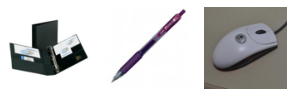

[ 도메인 추정결과 ]
추정확률분포 [65,15,20] => 추정 amazon : 정답 amazon => O
추정확률분포 [65,15,20] => 추정 amazon : 정답 amazon => O
추정확률분포 [65,15,20] => 추정 amazon : 정답 dslr => X
[ 상품 추정결과 ]
추정확률분포 [ 3, 3, 3, 3, 3, 3, 3, 3,...] => 추정 monitor : 정답 ring_binder => X
추정확률분포 [ 3, 3, 3, 3, 3, 3, 3, 3,...] => 추정 monitor : 정답 pen => X
추정확률분포 [ 3, 3, 3, 3, 3, 3, 3, 3,...] => 추정 monitor : 정답 mouse => X


In [16]:
om1 = AdamModel('office31_model_1', od, [10])
om1.exec_all(epoch_count=20, report=10)

    학습 결과 3가지를 분류하는 도메인은 60% 내외를 순회하였으며, 31가지를 분류하는 오브젝트에 관해서는 5%미만의 정확도를 보여주었다.  
    오브젝트의 추정확률분포만 봐도 모두 동일한 분포값을 가지고 있다는 것을 확인할 수 있으며, 
    이를 통해 단일 은닉 계층으로는 학습이 이뤄지지 않았다는 것을 알 수 있었습니다.


##### 실험2 - Adam 사용하지 않은 모델

    은닉 계층의 수와 폭을 대폭 늘려보았습니다. 뿐만 아니라 학습 횟수, 학습률 모두 더 나은 학습을 위해 값을 조정하였습니다.


Model office31_model_2 train started:
Epoch 10: cost=3.749, accuracy=0.804+0.091/0.860+0.090 (99/99 secs)
Epoch 20: cost=3.478, accuracy=0.851+0.141/0.840+0.110 (107/206 secs)
Epoch 30: cost=3.273, accuracy=0.868+0.192/0.840+0.090 (107/313 secs)
Epoch 40: cost=3.123, accuracy=0.882+0.214/0.900+0.130 (103/416 secs)
Epoch 50: cost=2.985, accuracy=0.887+0.247/0.870+0.140 (108/524 secs)
Model office31_model_2 train ended in 524 secs:
Model office31_model_2 test report: accuracy = 0.867+0.195, (0 secs)

Model office31_model_2 Visualization


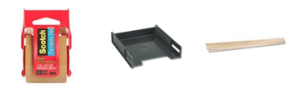

[ 도메인 추정결과 ]
추정확률분포 [100, 0, 0] => 추정 amazon : 정답 amazon => O
추정확률분포 [100, 0, 0] => 추정 amazon : 정답 amazon => O
추정확률분포 [95, 0, 5] => 추정 amazon : 정답 amazon => O
[ 상품 추정결과 ]
추정확률분포 [ 6, 0, 0,20, 1,11, 7, 8,...] => 추정 bookcase : 정답 tape_dispenser => X
추정확률분포 [ 0, 1, 3, 0, 0, 0, 0, 0,...] => 추정 keyboard : 정답 letter_tray => X
추정확률분포 [ 0, 5, 0, 1, 1, 3, 1, 5,...] => 추정 pen : 정답 ruler => X


In [17]:
om2 = AdamModel('office31_model_2', od, [64, 32, 10])
om2.exec_all(epoch_count=50, report=10, learning_rate=0.0001)

    이전과 달리 학습 시간부터 굉장히 늘어난 것을 확인할 수 있는데, 
    이는 더 낮아진 학습률, 더 복잡해진 은닉 계층의 수와 폭으로 인해 파라미터의 증가, 갱신의 폭 축소로 이어지게 된 것 입니다.
    반면 도메인과 오브젝트 모두 정확도가 소폭 상승한 것을 확인할 수 있습니다.

    도메인의 경우 기존 약 60% 에서 80% 까지 +20% 상승하였으며, 
    오브젝트의 경우 5%미만의 정확도에서 4~5배인 20% 까지 정확도가 상승하게 되었습니다.

    추정확률분포만 봐도 이전에는 모두 동일한 결과를 보였지만 지금은 어느정도 정답을 찾기위한 분포를 보여주고 있습니다.
    하지만 아직까지 만족스러운 결과는 보여주지 못하고 있습니다.


##### 실험3 - Adam 사용

    아담 알고리즘에 대한 플래그값을 True 로 전환하여 학습을 수행

Model office31_model_3 train started:
Epoch 10: cost=3.708, accuracy=0.818+0.089/0.870+0.050 (106/106 secs)
Epoch 20: cost=3.303, accuracy=0.867+0.166/0.860+0.150 (100/206 secs)
Epoch 30: cost=3.096, accuracy=0.883+0.202/0.880+0.180 (97/303 secs)
Epoch 40: cost=2.931, accuracy=0.894+0.242/0.880+0.230 (103/406 secs)
Epoch 50: cost=2.798, accuracy=0.902+0.272/0.870+0.170 (96/502 secs)
Model office31_model_3 train ended in 502 secs:
Model office31_model_3 test report: accuracy = 0.882+0.237, (0 secs)

Model office31_model_3 Visualization


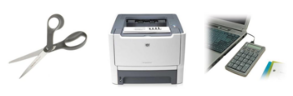

[ 도메인 추정결과 ]
추정확률분포 [99, 0, 0] => 추정 amazon : 정답 amazon => O
추정확률분포 [100, 0, 0] => 추정 amazon : 정답 amazon => O
추정확률분포 [100, 0, 0] => 추정 amazon : 정답 amazon => O
[ 상품 추정결과 ]
추정확률분포 [ 0, 1, 0, 2, 5, 2, 1,13,...] => 추정 desk_lamp : 정답 scissors => X
추정확률분포 [ 2, 2, 1, 9, 7, 2, 0,12,...] => 추정 paper_notebook : 정답 printer => X
추정확률분포 [ 0, 0, 2, 2, 0, 1, 2, 1,...] => 추정 headphones : 정답 calculator => X


In [18]:
om3 = AdamModel('office31_model_3', od, [64, 32, 10])
om2.use_adam = True
om3.exec_all(epoch_count=50, report=10, learning_rate=0.0001)

    이미지 분류 문제를 다층 퍼셉트론으로 풀어낸 것에 대한 한계가 존재하기는 하지만, 
    아담 알고리즘을 이용한다고 무조건 학습 결과가 대폭 향상된다는 것은 아니라는 결과를 얻어내었습니다. 

    최적화 알고리즘은 앞서 살펴본 Momentum, AdaGrad, RMSProp 외에도 더 다양하게 존재합니다.
    그리고 각 알고리즘이 갖는 장점과 단점 모두 명확하기에 무조건 Adam을 사용하는 것 보다는 
    자신의 실험 환경에 맞는 최적화 알고리즘을 탐색하여 적용하는 방법을 조심스럽게 권해 보는 바입니다.
